In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# Load utility functions from detect_clusters.py
import detect_clusters
import matplotlib.pyplot as plt

In [19]:
import skimage
from skimage.io import imread
from skimage.measure import regionprops
import numpy as np
import math
from os.path import join
import pandas as pd
import os
from os.path import join
from pathlib import Path

In [5]:
from detect_clusters import track_cells, matchClusters, detectAndTrackClusters, generate_graph
from pathlib import Path
import os
from skimage.io import imsave
from detect_clusters import computeVelocities, computeRelativeVelocities
from detect_clusters import EdgeFilterAngleCountVelocity
from detect_clusters import labels2rgb, rag_attribute_image, show_rag2
from detect_clusters import rag_velocity_image, vel2rgb
from detect_clusters import to_pandas_nodelist
from detect_clusters import loadDPTracks, EdgeFilterNone

In [20]:
DATADIR = Path('../data/')

# Load image and display

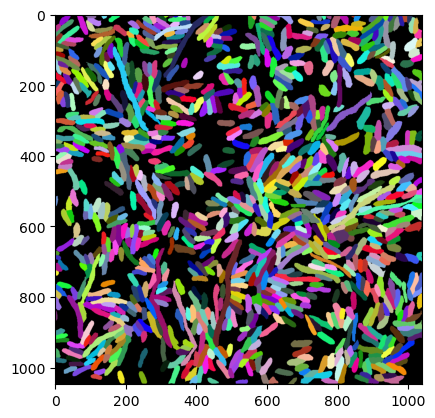

In [21]:
#%matplotlib ipympl
%matplotlib inline
n = 20000
L = imread( DATADIR / f'71024_Dynamic_Pack_Masks/7-10-24 Dynamic Pack Masks/7-3-24 dynamic packs-{n}_cp_masks.png')

plt.imshow( labels2rgb(L) )

# Integrated processing with tracking

### Old dataset

In [ ]:
# Old data
ns=[0,1,2,3,5,6,7,8,9]

indir = DATADIR / 'bacteriamasks'
outdir = DATADIR / 'bacteriaclusters_vel_a15_c30_v10'
names = [f'wbeads000{n}_cp_masks.png' for n in ns]

df = None

### New dataset

In [22]:
# Prepare id=>trackid relabeling of new data

ns=list(range(20000,20050))
indir = DATADIR / '71024_Dynamic_Pack_Masks/7-10-24 Dynamic Pack Masks'
outdir = DATADIR / '71024_Dynamic_Pack_Masks/7-10-24_DynPackClusters/'
names = [f'7-3-24 dynamic packs-{n}_cp_masks.png' for n in ns]

In [35]:
df = loadDPTracks(DATADIR / '71024_Dynamic_Pack_Masks/DPTracks.csv')

next_id = df['trackid'].max()+1

print(f'Loaded {df.shape[0]} detections in {df.frame.unique().size} unique frames, {df.trackid.unique().size} unique trackid.')
print(f'{df.shape[0]/df.trackid.unique().size:.03} average detections per trackid.')

#print(f'next_id={next_id}')
df

Loaded 49906 detections in 50 unique frames, 5786 unique trackid.
8.63 average detections per trackid.


trackid  frame          cx          cy
0            1      5  175.668781  907.271242
1            1      6  180.954619  898.049799
2            1      7  189.868346  887.730082
3            1      8  197.300579  877.831886
4            2      0  830.101109  279.333237
...        ...    ...         ...         ...
49901     5784     44  560.511714  305.088019
49902     5785     43  221.269058  318.539100
49903     5785     44  233.438195  325.614818
49904     5786     43  677.100170  323.111253
49905     5786     44  664.529287  326.264493

[49906 rows x 4 columns]

## New new dataset June 18

[<PIL.Image.Image image mode=I;16B size=356x333 at 0x7FD68C70F9A0>, <PIL.Image.Image image mode=I;16B size=356x333 at 0x7FD68C70D270>, <PIL.Image.Image image mode=I;16B size=356x333 at 0x7FD68C70D2D0>, <PIL.Image.Image image mode=I;16B size=356x333 at 0x7FD68C70C5B0>, <PIL.Image.Image image mode=I;16B size=356x333 at 0x7FD68C70D510>, <PIL.Image.Image image mode=I;16B size=356x333 at 0x7FD68C70D630>, <PIL.Image.Image image mode=I;16B size=356x333 at 0x7FD68C70D210>, <PIL.Image.Image image mode=I;16B size=356x333 at 0x7FD68C70F6D0>, <PIL.Image.Image image mode=I;16B size=356x333 at 0x7FD68C70CDC0>, <PIL.Image.Image image mode=I;16B size=356x333 at 0x7FD68C70DFF0>, <PIL.Image.Image image mode=I;16B size=356x333 at 0x7FD68C70E1A0>, <PIL.Image.Image image mode=I;16B size=356x333 at 0x7FD68C70DFC0>, <PIL.Image.Image image mode=I;16B size=356x333 at 0x7FD68C70C940>, <PIL.Image.Image image mode=I;16B size=356x333 at 0x7FD68C70D060>, <PIL.Image.Image image mode=I;16B size=356x333 at 0x7FD68C70C

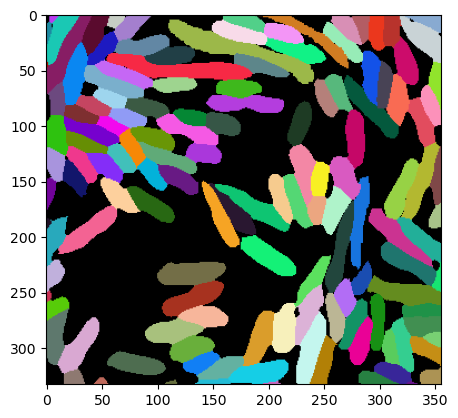

In [63]:
from PIL import Image

def load_multiframe_tiff(filepath):
    """
    Loads a multi-frame TIFF image and returns a list of PIL Image objects, 
    one for each frame.
    """
    frames = []
    try:
        img = Image.open(filepath)
        i = 0
        while True:
            try:
                img.seek(i)
                frames.append(img.copy())  # Append a copy of the current frame
                i += 1
            except EOFError:
                # End of frames reached
                break
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return frames

img = load_multiframe_tiff(DATADIR / 'labelimages.tif')

print(img)

plt.figure()
L = np.array(img[0])
plt.imshow(labels2rgb( L ))

In [40]:
df0 = pd.read_csv(DATADIR / 'original_spotswithedits.csv',
                  header=0, skiprows=[1,2,3], )

# Clean up
df = df0[['TRACK_ID','FRAME','POSITION_X','POSITION_Y']]
df.columns = ['trackid','frame','cx','cy']
df = df.sort_values(['frame','trackid'])

display(df0)
display(df)

LABEL      ID  TRACK_ID  QUALITY  POSITION_X  POSITION_Y  POSITION_Z  \
0     ID119585  119585         0      107  352.179245   73.407233           0   
1     ID117760  117760         0      650  330.952729   55.093133           0   
2     ID118757  118757         0      842  335.298028   74.017160           0   
3     ID118148  118148         0      360  344.978502   66.694637           0   
4     ID118820  118820         0      257  347.855943   69.562016           0   
...        ...     ...       ...      ...         ...         ...         ...   
6250  ID122701  122701       518       43    0.182171  104.670543           0   
6251  ID123023  123023       518       53    0.326923  114.105769           0   
6252  ID117683  117683       521      427  341.581282  301.605119           0   
6253  ID117685  117685       521      579  339.278947  303.172807           0   
6254  ID117812  117812       521      607  331.683852  314.727496           0   

      POSITION_T  FRAME     RADIUS  ...          ELLIPSE_Y0  \
0             16     16   5.808687  ...  1.4072330638129549   
1              2      2  14.389600  ...         -0.03790829   
2             13     13  16.400361  ...        -0.041439164   
3              8      8  10.712176  ...        -0.410095367   
4             14     14   9.062227  ...  0.5876411313511996   
...          ...    ...        ...  ...                 ...   
6250          44     44   3.699639  ...        -0.154032662   
6251          45     45   4.068429  ...        -0.349485806   
6252           0      0  11.651574  ...  1.4161587741782493   
6253           1      1  13.469842  ...         0.361011567   
6254           2      2  13.945872  ...  0.6197329191184298   

           ELLIPSE_MAJOR       ELLIPSE_MINOR  ELLIPSE_THETA  \
0      9.778075014549986   5.404708792478747       1.224318   
1      21.85713268594095   9.825987157383496       1.348738   
2     27.121954285912523  11.158361527084878      -0.130749   
3     15.206498565208689   8.523780753003441       2.555069   
4     12.703562981785604         8.906698317       0.266333   
...                  ...                 ...            ...   
6250  6.9757618156149865   2.329216961146131       1.548454   
6251   7.754008747645658   2.766620361881755      -1.532486   
6252   20.56933987226091   8.222760984969403       0.581160   
6253   24.91782011388856   7.791384082173172       0.768596   
6254   28.36620253059133   7.025833460440161       0.751648   

      ELLIPSE_ASPECTRATIO   AREA   PERIMETER  CIRCULARITY  SOLIDITY  \
0      1.8091770324716225  106.0   46.834957     0.607261  0.933921   
1       2.224421051631128  650.5  107.339020     0.709483  0.958027   
2      2.4306395002598675  845.0  121.703463     0.716904  0.938368   
3       1.784008646615004  360.5   76.553587     0.773008  0.967785   
4      1.4262931705171542  258.0   63.528557     0.803326  0.977273   
...                   ...    ...         ...          ...       ...   
6250   2.9948956803845546   43.0   34.180340     0.462515  0.905263   
6251   2.8027006720834162   52.0   36.953369     0.478526  0.928571   
6252   2.5015125588424785  426.5   95.061477     0.593089  0.875770   
6253    3.198124986663279  570.0  112.580387     0.565144  0.930612   
6254          4.037414591  611.0  128.595089     0.464304  0.915356   

     SHAPE_INDEX  
0       4.549013  
1       4.208564  
2       4.186726  
3       4.031929  
4       3.955115  
...          ...  
6250    5.212453  
6251    5.124510  
6252    4.603043  
6253    4.715474  
6254    5.202400  

[6255 rows x 31 columns]

trackid  frame          cx          cy
8           0      0  322.166667   43.691540
23          1      0  268.879619  254.695595
88          5      0  239.949052  238.205239
99          6      0   24.502481  326.756410
134         7      0  126.896579  104.277403
...       ...    ...         ...         ...
6232      509     49  302.337070  137.655456
6240      514     49  190.500000   -0.305556
6242      515     49  328.539325  309.916609
6244      516     49   34.603098   11.132917
6249      517     49   28.404843  166.846154

[6255 rows x 4 columns]

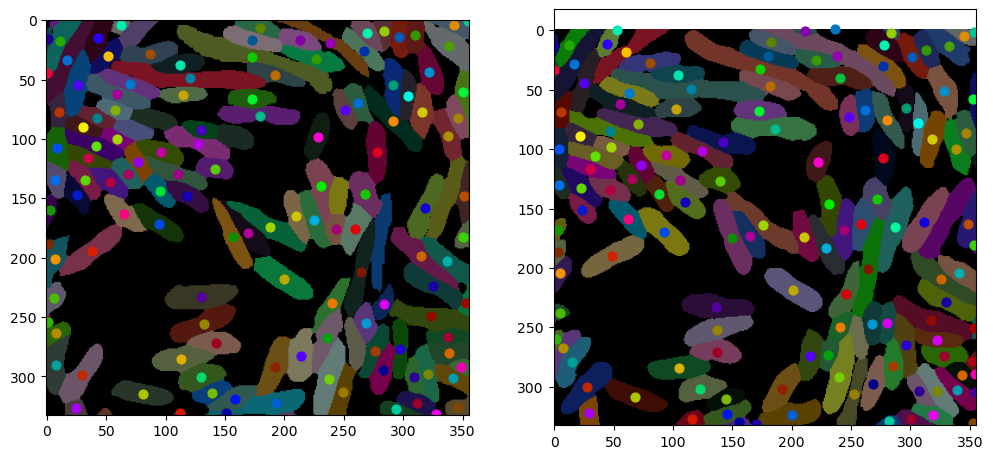

In [66]:
from detect_clusters import get_rgbmap

fig,axes = plt.subplots(1,2,figsize=(12,6))

frame0 = 0
frame1 = 1

plt.sca(axes[0])

cols = get_rgbmap(df.trackid.unique())


L = np.array(img[0])
plt.imshow(labels2rgb( L )*0.5) # Darker

for trackid in df.trackid.unique():
  track = df[ (df.trackid==trackid) & (df.frame==frame0) ]
  #alpha = (np.array((track.frame-frame0)/(frame1-frame0))*0.75+0.25).reshape(-1,1)  # Get a sense of time
  #plt.plot( track.cx, track.cy, '-', color=cols[trackid] *0.5 + 0.5, linewidth=0.5 )
  plt.scatter( track.cx, track.cy, 40, color=cols[trackid,:].reshape(3,) )


plt.sca(axes[1])

L = np.array(img[1])
plt.imshow(labels2rgb( L )*0.5)

for trackid in df.trackid.unique():
  track = df[ (df.trackid==trackid) & (df.frame==frame1) ]
  #alpha = (np.array((track.frame-frame0)/(frame1-frame0))*0.75+0.25).reshape(-1,1)  # Get a sense of time
  #plt.plot( track.cx, track.cy, '-', color=cols[trackid] *0.5 + 0.5, linewidth=0.5 )
  plt.scatter( track.cx, track.cy, 40, color=cols[trackid,:].reshape(3,) )

### Plotting multiple frames with consistent color

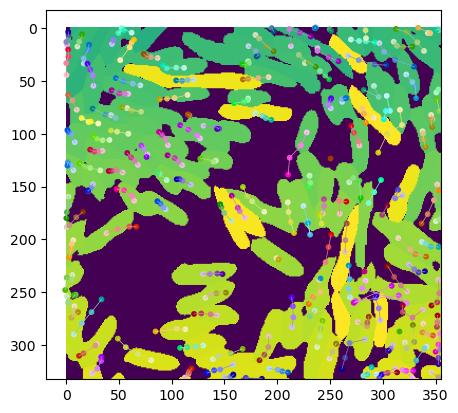

In [58]:
from detect_clusters import get_rgbmap


# Interval to show
frame0=0
frame1=3

plt.imshow( img[frame0] )

cols = get_rgbmap(df.trackid.unique())

for trackid in df.trackid.unique():
  track = df[ (df.trackid==trackid) & (df.frame>=frame0) & (df.frame<=frame1) ]
  alpha = (np.array((track.frame-frame0)/(frame1-frame0))*0.75+0.25).reshape(-1,1)  # Get a sense of time
  plt.plot( track.cx, track.cy, '-', color=cols[trackid] *0.5 + 0.5, linewidth=0.5 )
  plt.scatter( track.cx, track.cy, 10, cols[trackid,:] * alpha + (1-alpha) )
#plt.xlim(0,350)
#plt.ylim(350,0)

### Convert all to RAG data structures for processing velocities and other attributes

TODO: convert image loading to multi-frame TIFF from the latest data from Danielle

In [ ]:
from detect_clusters import EdgeFilterAngleCountVelocity
from detect_clusters import rag_velocity_image, vel2rgb, show_rag2, EdgeFilterNone,xylim
from detect_clusters import generate_graph, trackidFromDPTrack, track_cells, detectAndTrackClusters
from detect_clusters import computeVelocities, computeAreaChange
from detect_clusters import labels2rgb, rag_attribute_image, rag_velocity_image
from skimage.io import imsave

# ASSUMES DATASET IS DEFINED
# indir, outdir, names, df, next_id

#outdir = '/home/rmegret/PROBE/71024_Dynamic_Pack_Masks/7-10-24_DynPack_track_clusters/'
#df = None

#edge_filter = EdgeFilterAngleCount(amax=15, count_min=30) 
edge_filter = EdgeFilterAngleCountVelocity(amax=15, count_min=30, vdiffmax=10)

for subdir in [ 'id_rgb', 'trackid', 'trackid_rgb', 
                'clustertrack', 'clustertrack_rgb', 
                'velocity_back_rgb', 'velocity_back_arrows', 'area_change_back' ]:
  os.makedirs( join(outdir, subdir), exist_ok=True)

L2 = None;  rag2 = None
next_id = None
next_cid = None
#for i in range(4):
for i in range(len(names)):
  L1 = L2;   rag1 = rag2

  name = names[i]
  inputfile = join(indir,name)
  print(inputfile)
  L2 = imread(inputfile)

  # PROCESSING

  ## 1. RAG graph
  rag2 = generate_graph(L2)

  ## 2. trackid
  if (df is not None):
    df1 = df[df.frame==i]
    next_id = trackidFromDPTrack(rag2, df1, next_id=next_id)
  else: # Track ourselves
    next_id = track_cells(rag2, L2, rag1, L1, next_id=next_id)
    
  ## 3. node spatio-temporal properties
  computeVelocities(rag1, rag2)
  computeAreaChange(rag1, rag2)

  ## 4. clusters
  next_cid = detectAndTrackClusters(rag2, L2, rag1, L1, 
                                edge_filter = edge_filter,
                                cluster_metric='count',
                                cluster_thresh=1, 
                                next_cid=next_cid)

  # VISUALIZATIONS

  Lrgb = labels2rgb(L2.astype(int))
  KT = rag_attribute_image(L2, rag2, 'trackid').astype(int)
  KTrgb = labels2rgb(KT)
  KC = rag_attribute_image(L2, rag2, 'clustertrack').astype(int)
  KCrgb = labels2rgb(KC)

  vmax = 10

  V2 = rag_velocity_image(L2, rag2, 'velocity_back').astype(float)
  bg2 = rag_attribute_image(L2, rag2, 'id') == 0
  Vrgb2 = vel2rgb(V2, velocity_max = vmax)
  Vrgb2[bg2,:] = 0.5

  A = rag_attribute_image(L2, rag2, 'area_change_back')
  A = np.clip( A+0.5, 0,1 )
  Argb = plt.cm.bwr(A)
  Argb[bg2,:] = 0.5

  imsave(join(outdir,'id_rgb',f'{name}_id_rgb.png'), np.uint8(Lrgb*255.0))
  imsave(join(outdir,'trackid',f'{name}_trackid.png'), KT.astype(np.int16), check_contrast=False)
  imsave(join(outdir,'trackid_rgb',f'{name}_trackid_rgb.png'), np.uint8(KTrgb*255.0))
  imsave(join(outdir,'clustertrack',f'{name}_cluster.png'), KC.astype(np.int16), check_contrast=False)
  imsave(join(outdir,'clustertrack_rgb',f'{name}_clustertrack_rgb.png'), np.uint8(KCrgb*255.0))
  imsave(join(outdir,'velocity_back_rgb',f'{name}_velocity_back_rgb.png'), np.uint8(Vrgb2*255.0))
  imsave(join(outdir,'area_change_back',f'{name}area_change_back.png'), np.uint8(Argb*255.0))

  r = [0,L2.shape[1], L2.shape[1],0]

  s = 8
  vs = 1
  fig,ax = plt.subplots(1,1,figsize=(s,s))
  show_rag2(L2, rag2, Vrgb2, img_cmap=None, ax=ax, border_color='blue', edge_width=3, edge_cmap='magma', 
            hide_zero=True, edge_filter=EdgeFilterNone(), show_filtered=False, ignore_node=0,
            velocity_back=True, velocity_scale=vs, arrow_config=dict(width=0.3, color='k'), )
  plt.title(f'{name} - vmax={vmax}, vscale={vs}')
  xylim(r)
  plt.tight_layout()
  plt.savefig( join(outdir,'velocity_back_arrows',f'{name}_velocity_back_arrows.pdf') )
  plt.savefig( join(outdir,'velocity_back_arrows',f'PNG_{name}_velocity_back_arrows.png') )
  plt.close(fig)

  # show_rag2 does not support cmap borders yet
  fig,ax = plt.subplots(1,1,figsize=(s,s))
  show_rag2(L2, rag2, Argb, img_cmap=None, ax=ax, node_feature='trackid', edge_width=3, edge_cmap='bwr', 
            hide_zero=True, edge_filter=EdgeFilterNone(), show_filtered=False, ignore_node=0 )
  plt.title(f'{name} - area_change_back, clim=[-1,1] log2 scale')
  xylim(r)
  plt.tight_layout()
  plt.savefig( join(outdir,'area_change_back',f'LABEL_{name}_area_change_back.png') )
  plt.close(fig)

In [ ]:
K1 = rag_attribute_image(L1, rag1, 'trackid').astype(int)
K2 = rag_attribute_image(L2, rag2, 'trackid').astype(int)
K3 = rag_attribute_image(L3, rag3, 'trackid').astype(int)

Krgb1 = labels2rgb(K1)
Krgb2 = labels2rgb(K2)
Krgb3 = labels2rgb(K3)

fig,ax = plt.subplots(1,3,figsize=(12,4))
show_rag2(L1, rag1, Krgb1, img_cmap=None, ax=ax[0], border_color='blue', dataname='max_count_ratio', edge_width=3, edge_cmap='magma', hide_zero=True, edge_filter=EdgeFilterNone(), show_filtered=False, ignore_node=0)
xylim(r, ax[0])
show_rag2(L2, rag2, Krgb2, img_cmap=None, ax=ax[1], border_color='blue', dataname='max_count_ratio', edge_width=3, edge_cmap='magma', hide_zero=True, edge_filter=EdgeFilterNone(), show_filtered=False, ignore_node=0)
xylim(r, ax[1])
show_rag2(L3, rag3, Krgb3, img_cmap=None, ax=ax[2], border_color='blue', dataname='max_count_ratio', edge_width=3, edge_cmap='magma', hide_zero=True, edge_filter=EdgeFilterNone(), show_filtered=False, ignore_node=0)
xylim(r, ax[2])

<Axes: >

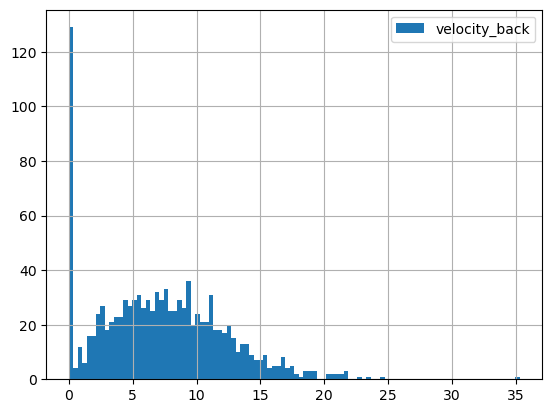

In [ ]:
#computeVelocities(rag1, rag2)
import pandas as pd
data = dict(rag2.nodes.data())
df = pd.DataFrame(data.values(), index=data.keys())
#df['velocity_back'].apply(lambda d: pd.Series(d, index=['vx','vy']))
df['velocity_back'].apply(lambda d: pd.Series(d, index=['vx','vy']))

vs = df['velocity_back'].apply(lambda d: np.linalg.vector_norm(d))
vs.hist(bins=100,legend='velocity')

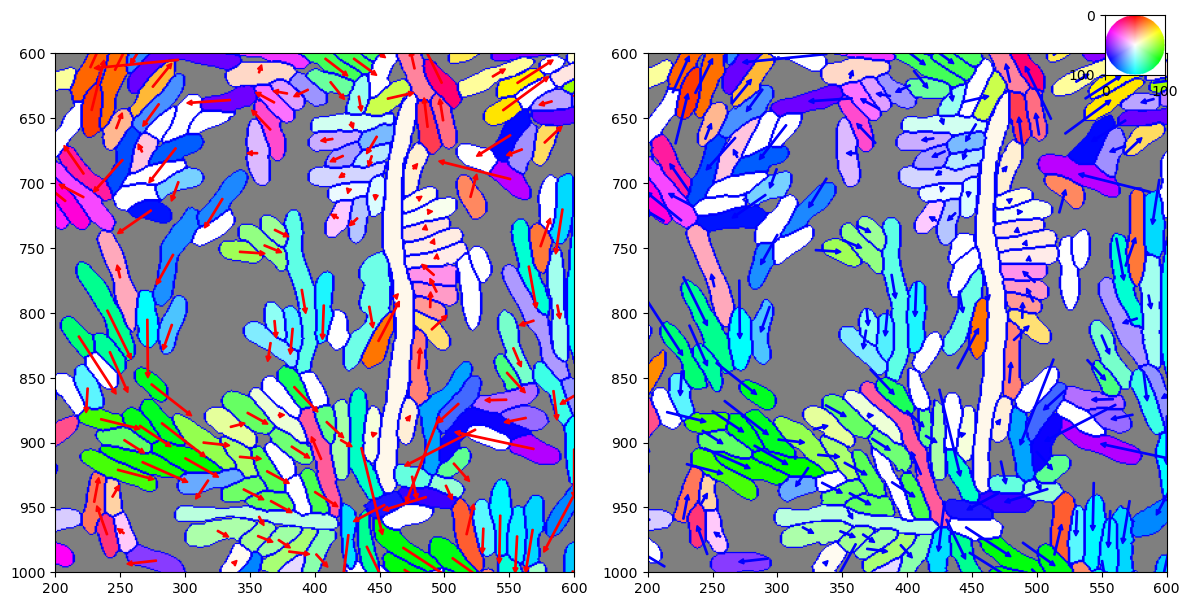

In [151]:
from detect_clusters import rag_velocity_image, vel2rgb, show_rag2, EdgeFilterNone,xylim
V = rag_velocity_image(L1, rag1, 'velocity_front').astype(float)
bg = rag_attribute_image(L1, rag1, 'id') == 0
Vrgb = vel2rgb(V, velocity_max = 10)
Vrgb[bg,:] = 0.5
#plt.imshow(Vrgb)

V2 = rag_velocity_image(L2, rag2, 'velocity_back').astype(float)
bg2 = rag_attribute_image(L2, rag2, 'id') == 0
Vrgb2 = vel2rgb(V2, velocity_max = 10)
Vrgb2[bg2,:] = 0.5

s=6
vs = 3
r = [200,600, 1000,600]

fig,ax = plt.subplots(1,2,figsize=(2*s,s))
show_rag2(L1, rag1, Vrgb, img_cmap=None, ax=ax[0], border_color='blue', velocity_front=True, velocity_scale=vs, edge_width=3, edge_cmap='magma', hide_zero=True, edge_filter=EdgeFilterNone(), show_filtered=False, ignore_node=0)
xylim(r, ax[0])

show_rag2(L2, rag2, Vrgb2, img_cmap=None, ax=ax[1], border_color='blue', velocity_back=True, velocity_scale=vs, edge_width=3, edge_cmap='magma', hide_zero=True, edge_filter=EdgeFilterNone(), show_filtered=False, ignore_node=0)
xylim(r, ax[1])

fig.tight_layout()

axhue = fig.add_axes( (0.9,0.9,0.1,0.1) )
xs = np.linspace(-1,1,101)
ys = np.linspace(-1,1,101)
Vlegend = vel2rgb(np.stack(np.meshgrid(ys,xs,indexing='ij'),axis=-1), clip_magnitude=False)
axhue.imshow(Vlegend)

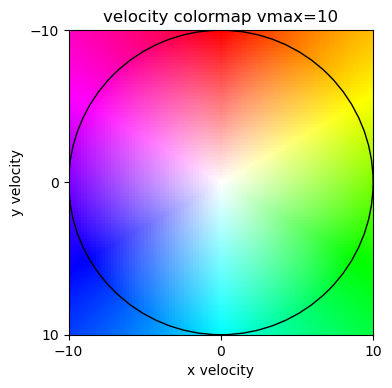

In [ ]:
import matplotlib


fig,ax = plt.subplots(1,1,figsize=(4,4))
vmax=10
xs = np.linspace(-1,1,101)
ys = np.linspace(-1,1,101)
Vlegend = vel2rgb(np.stack(np.meshgrid(ys,xs,indexing='ij'),axis=-1), clip_magnitude=True)
plt.imshow(Vlegend, extent=[-vmax,vmax,vmax,-vmax])
plt.xticks([-vmax,0,vmax])
plt.yticks([-vmax,0,vmax])
plt.xlabel('x velocity')
plt.ylabel('y velocity')
plt.title(f'velocity colormap vmax={vmax}')
ax.add_patch(matplotlib.patches.Circle((0,0),10, edgecolor='k',facecolor='#fff0'))
plt.tight_layout()
plt.savefig(join(outdir,'velocity_legend.png'))

# Napari tracking proof-of-concept

Install config env.yaml
```
laptrack
napari
```


In [9]:
from laptrack import LapTrack
from laptrack import datasets
from laptrack.data_conversion import convert_split_merge_df_to_napari_graph
from laptrack import OverLapTrack
import pandas as pd
from skimage.measure import regionprops_table
from skimage.io import imread
from os.path import join
import numpy as np

In [10]:
lt = LapTrack(cutoff=15**2, splitting_cutoff=30**2)
olt = OverLapTrack(
    cutoff=0.9,
    metric_coefs = (1.0, -1.0, -1.0, 0.0, 0.0),
    gap_closing_metric_coefs = (1.0, -1.0, 0.0, 0.0, 0.0),
    gap_closing_max_frame_count=1,
    splitting_cutoff=0.9,
    splitting_metric_coefs = (1.0, 0.0, 0.0, 0.0, -1.0),
    merging_cutoff=0.9,
    merging_metric_coefs = (1.0, 0.0, 0.0, -1.0, 0.0)

)

In [ ]:
# Toy dataset
#labels = datasets.mouse_epidermis()
#labels.shape

In [11]:
N = len(names)
N = 5

LL = []
for i in range(N):
  name = names[i]
  inputfile = join(indir,name)
  print(inputfile)
  L2 = imread(inputfile)
  LL.append(L2)
labels = np.stack(LL, axis=0)
labels.shape

/home/rmegret/PROBE/71024_Dynamic_Pack_Masks/7-10-24 Dynamic Pack Masks/7-3-24 dynamic packs-20000_cp_masks.png
/home/rmegret/PROBE/71024_Dynamic_Pack_Masks/7-10-24 Dynamic Pack Masks/7-3-24 dynamic packs-20001_cp_masks.png
/home/rmegret/PROBE/71024_Dynamic_Pack_Masks/7-10-24 Dynamic Pack Masks/7-3-24 dynamic packs-20002_cp_masks.png
/home/rmegret/PROBE/71024_Dynamic_Pack_Masks/7-10-24 Dynamic Pack Masks/7-3-24 dynamic packs-20003_cp_masks.png
/home/rmegret/PROBE/71024_Dynamic_Pack_Masks/7-10-24 Dynamic Pack Masks/7-3-24 dynamic packs-20004_cp_masks.png


(5, 1048, 1040)

In [138]:
labels = np.zeros( (3,128,128), dtype=int )
labels[0, 30:40,5:25] = 101
labels[0, 30:40,50:100] = 102
labels[0, 60:70,50:60] = 200
labels[0, 60:70,70:80] = 201

labels[1, 30:40,5:14] = 103
labels[1, 30:40,16:25] = 104
labels[1, 30:40,50:60] = 105
labels[1, 30:40,65:85] = 106
labels[1, 30:40,90:100] = 107
labels[1, 60:70,50:80] = 202

labels[2, 30:40,5:25] = 10
labels[2, 30:40,50:60] = 11
labels[2, 30:40,65:100] = 12


In [12]:
track_df, split_df, merge_df = olt.predict_overlap_dataframe(labels)
track_df.shape, split_df.shape, merge_df.shape

((5387, 2), (164, 2), (174, 2))

Memo: 45s for 5 frames, 5387 items

In [13]:
dfs = []
for frame in range(len(labels)):
    df = pd.DataFrame(
        regionprops_table(labels[frame], properties=["label", "centroid"])
    )
    df["frame"] = frame
    dfs.append(df)
coordinate_df = pd.concat(dfs).set_index(["frame", "label"])
track_df2 = pd.merge(
    track_df, coordinate_df, right_index=True, left_index=True
).reset_index()
display(track_df2.head())
track_df2

split_parent = split_df.set_index('child_track_id')['parent_track_id'].to_dict()
print(split_parent)
split_children = split_df.groupby('parent_track_id')['child_track_id'].agg(list).to_dict()
print(split_children)
merge_child = merge_df.set_index('parent_track_id')['child_track_id'].to_dict()
print(merge_child)
merge_parents = merge_df.groupby('child_track_id')['parent_track_id'].agg(list).to_dict()
print(merge_parents)

trackframes_df = track_df2.groupby('track_id').agg({'frame': ['min', 'max']})
trackframes_df.columns = [f"{col[0]}_{col[1]}" for col in trackframes_df.columns]
trackframes_df
track_frame_start = trackframes_df['frame_min'].to_dict()
track_frame_end = trackframes_df['frame_max'].to_dict()
track_frame_start, track_frame_end

None


frame  label  tree_id  track_id  centroid-0  centroid-1
0      0      1        0         0    5.630719  101.872549
1      0      2        1         1    5.952941  138.511765
2      0      3        2         2   15.629534  261.406736
3      0      4        3         3    4.300885  313.831858
4      0      5        4         4    4.330435  341.347826

{1077: 1, 1070: 1, 1073: 11, 1078: 11, 1086: 164, 1083: 164, 1088: 199, 1087: 199, 1092: 377, 1093: 377, 1096: 459, 1097: 459, 1155: 482, 1156: 482, 1107: 644, 1110: 644, 1111: 656, 1116: 656, 1112: 669, 1113: 669, 1127: 679, 1114: 679, 1118: 719, 1117: 719, 1120: 735, 1119: 735, 1121: 747, 1158: 747, 1157: 749, 1123: 749, 1122: 765, 1140: 765, 1132: 858, 1130: 858, 1134: 896, 1152: 896, 1139: 924, 1136: 924, 1142: 953, 1141: 953, 1146: 1015, 1147: 1015, 1145: 1020, 1151: 1020, 1080: 1030, 1081: 1030, 1079: 1032, 1082: 1032, 1076: 1034, 1075: 1034, 1098: 1064, 1100: 1064, 1169: 144, 1168: 144, 1173: 234, 1175: 234, 1179: 1090, 1174: 1090, 1176: 255, 1177: 255, 1234: 1065, 1235: 1065, 1181: 375, 1182: 375, 1184: 415, 1186: 415, 1195: 475, 1192: 475, 1190: 1099, 1189: 1099, 1193: 512, 1194: 512, 1198: 578, 1202: 578, 1208: 663, 1207: 663, 1204: 690, 1206: 690, 1213: 1122, 1225: 1122, 1216: 799, 1215: 799, 1217: 1039, 1218: 1039, 1221: 1038, 1223: 1038, 1219: 1132, 1220: 1132, 1222: 885, 

In [14]:
f1 = 0
f2 = 1

rag1 = generate_graph(labels[f1])
rag2 = generate_graph(labels[f2])

In [15]:
split_df0 = split_df.set_index('child_track_id')

for _,item in track_df2[track_df2.frame==f1].iterrows():
  rag1.nodes[item.label]['trackid'] = int(item.track_id)
  if (track_frame_start[item.track_id] == f1): 
    rag1.nodes[item.label]['merge_parents'] = merge_parents.get(item.track_id,[])
    rag1.nodes[item.label]['split_parent'] = split_parent.get(item.track_id,None)
  if (track_frame_end[item.track_id] == f1): 
    rag1.nodes[item.label]['split_children'] = split_children.get(item.track_id,[])
    rag1.nodes[item.label]['merge_child'] = merge_child.get(item.track_id,None)

for _,item in track_df2[track_df2.frame==f2].iterrows():
  rag2.nodes[item.label]['trackid'] = int(item.track_id)
  if (track_frame_start[item.track_id] == f2): 
    rag2.nodes[item.label]['merge_parents'] = merge_parents.get(item.track_id,[])
    rag2.nodes[item.label]['split_parent'] = split_parent.get(item.track_id,None)
  if (track_frame_end[item.track_id] == f2): 
    rag2.nodes[item.label]['split_children'] = split_children.get(item.track_id,[])
    rag2.nodes[item.label]['merge_child'] = merge_child.get(item.track_id,None)

In [185]:
rag1.nodes.get(1077)

In [16]:
for _,item in track_df2[track_df2.frame==f1].iterrows():
  rag1.nodes[item.label]['trackid'] = int(item.tree_id+1)
for _,item in track_df2[track_df2.frame==f2].iterrows():
  rag2.nodes[item.label]['trackid'] = int(item.tree_id+1)

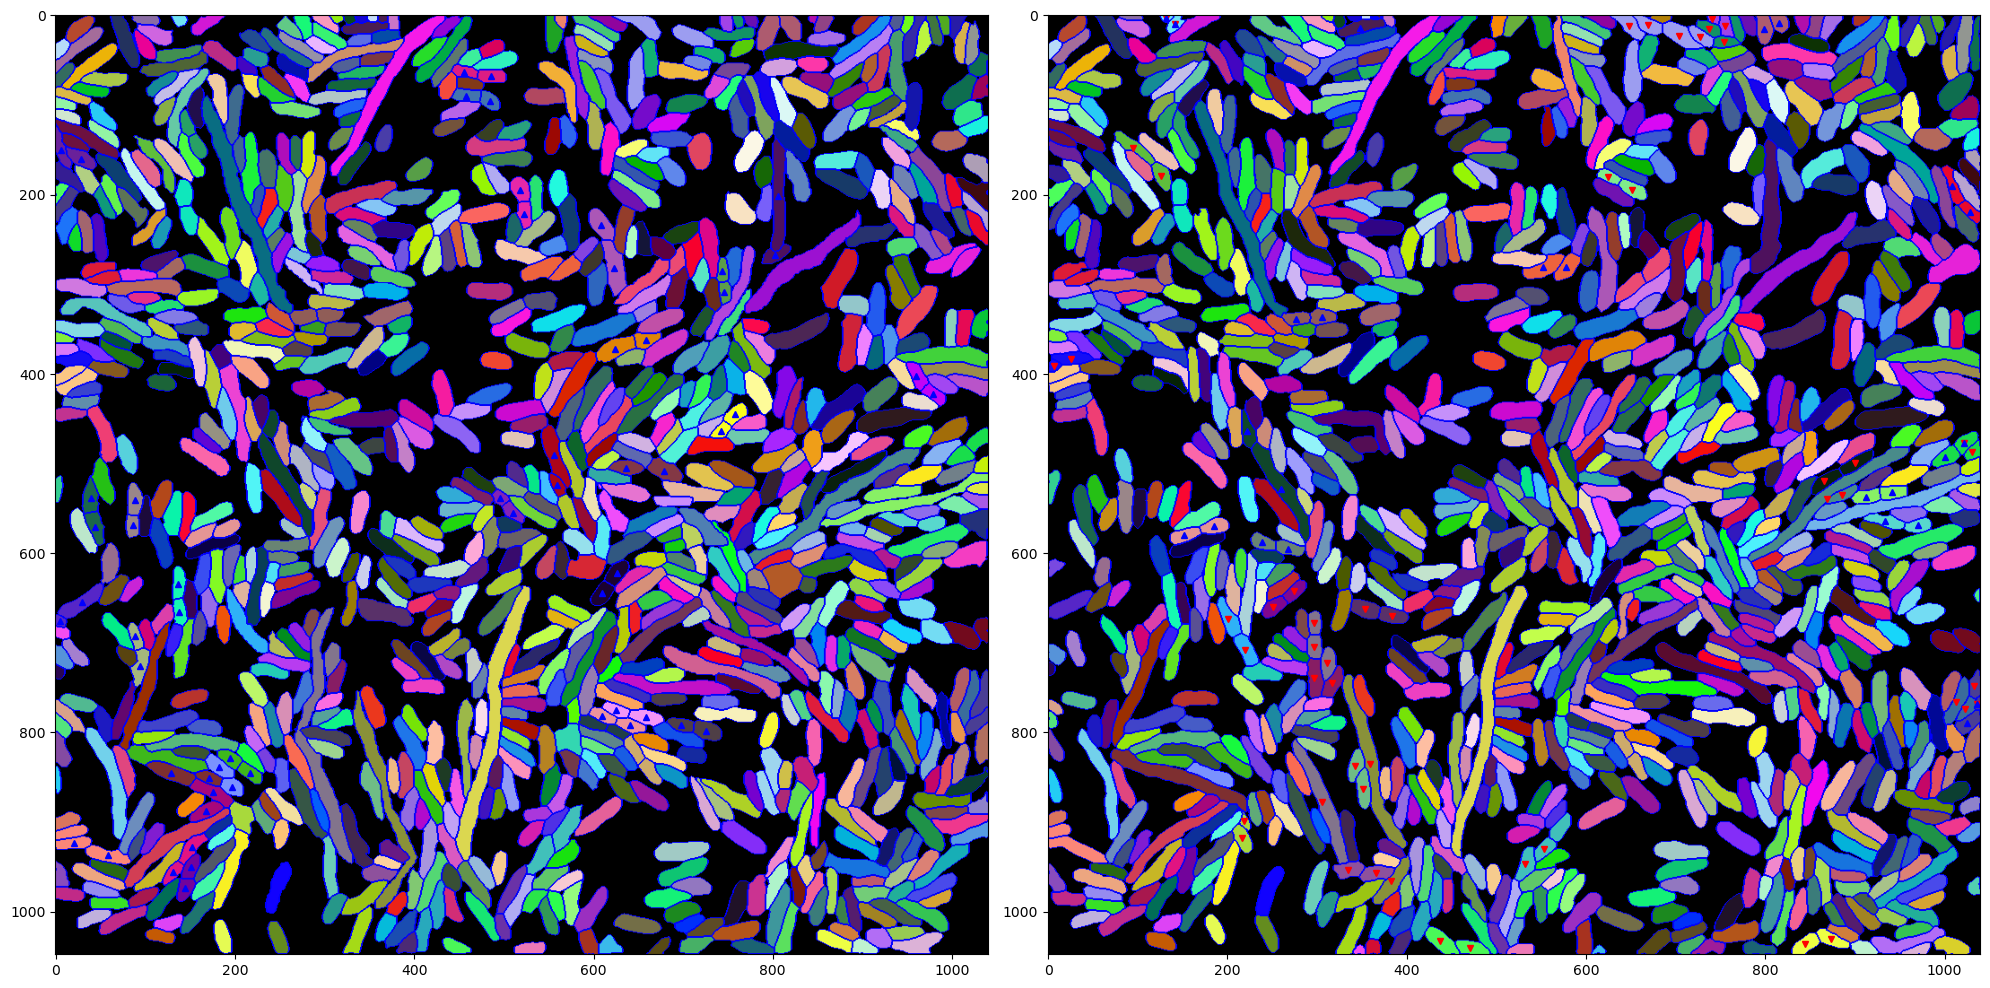

In [17]:
from detect_clusters import rag_velocity_image, vel2rgb, show_rag2, EdgeFilterNone,xylim

L1 = labels[f1]
L2 = labels[f2]

K1 = labels2rgb(L1)
K2 = labels2rgb(L2)

T1 = labels2rgb(rag_attribute_image(L1, rag1, 'trackid').astype(int))
T2 = labels2rgb(rag_attribute_image(L2, rag2, 'trackid').astype(int))

s=10
vs = 3
r = [200,600, 1000,600]

fig,ax = plt.subplots(1,2,figsize=(2*s,s))
show_rag2(L1, rag1, T1, img_cmap=None, ax=ax[0], node_feature='split_merge_indicator', border_color='blue', edge_width=3, edge_cmap='magma', hide_zero=True, edge_filter=EdgeFilterNone(), show_filtered=False, ignore_node=0)
#xylim(r, ax[0])

show_rag2(L2, rag2, T2, img_cmap=None, ax=ax[1], node_feature='split_merge_indicator', border_color='blue', edge_width=3, edge_cmap='magma', hide_zero=True, edge_filter=EdgeFilterNone(), show_filtered=False, ignore_node=0)
#xylim(r, ax[1])

fig.tight_layout()

## Napari viewer

In [10]:
from dotenv import load_dotenv

load_dotenv()

True

In [11]:
!echo PWD=$PWD
!echo DISPLAY=$DISPLAY
!echo LIBGL_ALWAYS_INDIRECT=$LIBGL_ALWAYS_INDIRECT
!echo LIBGL_ALWAYS_SOFTWARE=$LIBGL_ALWAYS_SOFTWARE

PWD=/home/rmegret/PROBE/cell_track_analysis
DISPLAY=192.168.0.14:0
LIBGL_ALWAYS_INDIRECT=0
LIBGL_ALWAYS_SOFTWARE=1


In [12]:
import napari

viewer = napari.Viewer()
#viewer.add_labels(labels)
napari.run()

In [13]:
viewer.add_labels(labels, name="labels")

<Labels layer 'labels' at 0x7ff0b641f100>

In [19]:
track_label_image = np.zeros_like(labels)
for (frame, label), row in track_df.iterrows():
    track_label_image[frame][labels[frame] == label] = row["track_id"] + 1

viewer.layers["labels"].visible = False
viewer.add_labels(track_label_image)

<Labels layer 'track_label_image [1]' at 0x7ff0b7251870>

In [20]:
graph = convert_split_merge_df_to_napari_graph(split_df, merge_df)
viewer.add_tracks(
    track_df2[["track_id", "frame", "centroid-0", "centroid-1"]].values,
    graph=graph,
    tail_length=1,
)

<Tracks layer 'Tracks' at 0x7ff0f1c1eef0>

: 

In [ ]:
K1 = rag_attribute_image(L1, rag1, 'trackid').astype(int)
K2 = rag_attribute_image(L2, rag2, 'trackid').astype(int)
Vrgb = rag_attribute_image(L1, rag1, 'velocity_front', mode='velocity', velocity_max=5.0).astype(float)

Krgb1 = labels2rgb(K1)
Krgb2 = labels2rgb(K2)

fig,ax = plt.subplots(1,3,figsize=(12,4))
show_rag2(L1, rag1, Krgb1, img_cmap=None, ax=ax[0], border_color='blue', dataname='max_count_ratio', edge_width=3, edge_cmap='magma', hide_zero=True, edge_filter=EdgeFilterNone(), show_filtered=False, ignore_node=0)
xylim(r, ax[0])
show_rag2(L2, rag2, Krgb2, img_cmap=None, ax=ax[1], border_color='blue', dataname='max_count_ratio', edge_width=3, edge_cmap='magma', hide_zero=True, edge_filter=EdgeFilterNone(), show_filtered=False, ignore_node=0)
xylim(r, ax[1])
show_rag2(L1, rag1, Vrgb, img_cmap=None, ax=ax[2], border_color='blue', dataname='max_count_ratio', edge_width=3, edge_cmap='magma', hide_zero=True, edge_filter=EdgeFilterNone(), show_filtered=False, ignore_node=0)
xylim(r, ax[2])

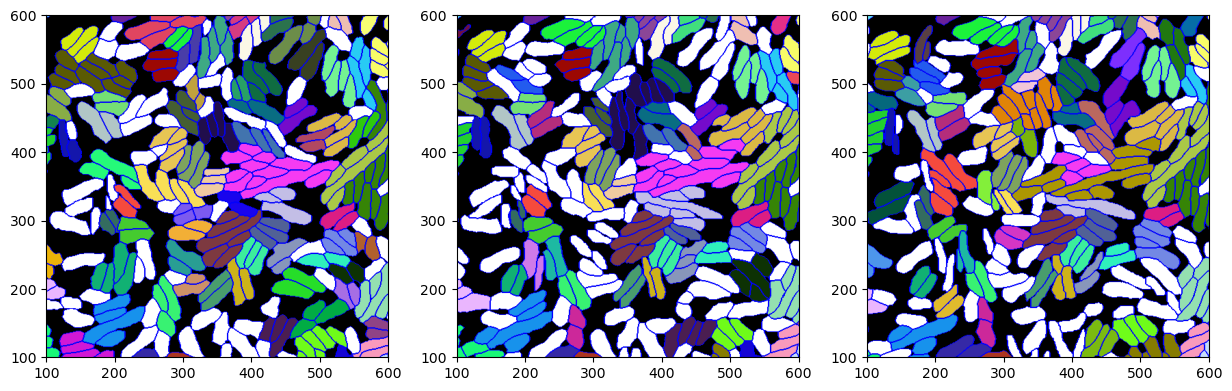

In [258]:
K1 = rag_attribute_image(L1, rag1, 'clustertrack').astype(int)
K2 = rag_attribute_image(L2, rag2, 'clustertrack').astype(int)
K3 = rag_attribute_image(L3, rag3, 'clustertrack').astype(int)

Krgb1 = labels2rgb(K1)
Krgb2 = labels2rgb(K2)
Krgb3 = labels2rgb(K3)

r = [100,600, 100,600]
s = 5

fig,ax = plt.subplots(1,3,figsize=(3*s,s))
show_rag2(L1, rag1, Krgb1, img_cmap=None, ax=ax[0], border_color='blue', dataname='max_count_ratio', edge_width=3, edge_cmap='magma', hide_zero=True, edge_filter=EdgeFilterNone(), show_filtered=False, ignore_node=0)
xylim(r, ax[0])
show_rag2(L2, rag2, Krgb2, img_cmap=None, ax=ax[1], border_color='blue', dataname='max_count_ratio', edge_width=3, edge_cmap='magma', hide_zero=True, edge_filter=EdgeFilterNone(), show_filtered=False, ignore_node=0)
xylim(r, ax[1])
show_rag2(L3, rag3, Krgb3, img_cmap=None, ax=ax[2], border_color='blue', dataname='max_count_ratio', edge_width=3, edge_cmap='magma', hide_zero=True, edge_filter=EdgeFilterNone(), show_filtered=False, ignore_node=0)
xylim(r, ax[2])

In [ ]:
n1 = int(L1.max())+1
map1toT = np.zeros( (n1,), dtype=int )
for u in rag1.nodes:
  node = rag1.nodes[u]
  map1toT[node['id']] = node['trackid']
L1T = map1toT[L1]

show_rag2(L1T, rag3, Krgb3, img_cmap=None, ax=ax[2], border_color='blue', dataname='max_count_ratio', edge_width=3, edge_cmap='magma', hide_zero=True, edge_filter=EdgeFilterNone(), show_filtered=False, ignore_node=0)
xylim(r, ax[2])

In [267]:
!mkdir -p bacteriamasks4/cc_rgb/ bacteriamasks4/cc_rgbb/ bacteriamasks4/cc/

In [295]:
folder='bacteriamasks0'

In [300]:
!mkdir -p {folder}/cc_rgb/ {folder}/cc_rgbb/ {folder}/cc/ {folder}/Lrgb/

In [302]:
from skimage.io import imsave

for kk in range(len(filenames)):
  f = filenames[kk]
  n = ns[kk]
  print(f, n)

  L = imread(f)

  outname = f'{folder}/cc/cc_wbeads000{n}_cp_clusters.tiff'
  rgbname = f'{folder}/cc_rgb/cc_rgb_wbeads000{n}_cp_rgbclusters.png'
  rgbbname = f'{folder}/cc_rgbb/cc_rgbb_wbeads000{n}_cp_rgbclusters.png'
  LRGBname = f'{folder}/Lrgb/Lrgb_wbeads000{n}_cp.png'

  print(f,outname,rgbname)
  
  rag = skimage.graph.rag_boundary(L, np.ones_like(L,dtype=np.float32))
  augment_graph(rag, L)
  compute_clusters(rag, min_cluster_size=3, edge_filter=edge_filter0)

  LRGB = labels2rgb(L)
  imsave(LRGBname, np.uint8(LRGB*255.0))

  LC = rag_attribute_image(L, rag, 'cluster').astype(np.int16)
  LCRGB = labels2rgb(LC)

  imsave(outname, LC)
  imsave(rgbname, np.uint8(LCRGB*255.0))

  LCRGB_boundaries = segmentation.mark_boundaries(LCRGB, L, color=[0,0,1.0])
  imsave(rgbbname, np.uint8(LCRGB_boundaries*255.0))

  

bacteriamasks/wbeads0000_cp_masks.png 0
bacteriamasks/wbeads0000_cp_masks.png bacteriamasks0/cc/cc_wbeads0000_cp_clusters.tiff bacteriamasks0/cc_rgb/cc_rgb_wbeads0000_cp_rgbclusters.png


/tmp/ipykernel_479/1983881363.py:27: UserWarning: bacteriamasks0/cc/cc_wbeads0000_cp_clusters.tiff is a low contrast image
  imsave(outname, LC)


bacteriamasks/wbeads0001_cp_masks.png 1
bacteriamasks/wbeads0001_cp_masks.png bacteriamasks0/cc/cc_wbeads0001_cp_clusters.tiff bacteriamasks0/cc_rgb/cc_rgb_wbeads0001_cp_rgbclusters.png


/tmp/ipykernel_479/1983881363.py:27: UserWarning: bacteriamasks0/cc/cc_wbeads0001_cp_clusters.tiff is a low contrast image
  imsave(outname, LC)


bacteriamasks/wbeads0002_cp_masks.png 2
bacteriamasks/wbeads0002_cp_masks.png bacteriamasks0/cc/cc_wbeads0002_cp_clusters.tiff bacteriamasks0/cc_rgb/cc_rgb_wbeads0002_cp_rgbclusters.png


/tmp/ipykernel_479/1983881363.py:27: UserWarning: bacteriamasks0/cc/cc_wbeads0002_cp_clusters.tiff is a low contrast image
  imsave(outname, LC)


bacteriamasks/wbeads0003_cp_masks.png 3
bacteriamasks/wbeads0003_cp_masks.png bacteriamasks0/cc/cc_wbeads0003_cp_clusters.tiff bacteriamasks0/cc_rgb/cc_rgb_wbeads0003_cp_rgbclusters.png


/tmp/ipykernel_479/1983881363.py:27: UserWarning: bacteriamasks0/cc/cc_wbeads0003_cp_clusters.tiff is a low contrast image
  imsave(outname, LC)


bacteriamasks/wbeads0005_cp_masks.png 5
bacteriamasks/wbeads0005_cp_masks.png bacteriamasks0/cc/cc_wbeads0005_cp_clusters.tiff bacteriamasks0/cc_rgb/cc_rgb_wbeads0005_cp_rgbclusters.png


/tmp/ipykernel_479/1983881363.py:27: UserWarning: bacteriamasks0/cc/cc_wbeads0005_cp_clusters.tiff is a low contrast image
  imsave(outname, LC)


bacteriamasks/wbeads0006_cp_masks.png 6
bacteriamasks/wbeads0006_cp_masks.png bacteriamasks0/cc/cc_wbeads0006_cp_clusters.tiff bacteriamasks0/cc_rgb/cc_rgb_wbeads0006_cp_rgbclusters.png


/tmp/ipykernel_479/1983881363.py:27: UserWarning: bacteriamasks0/cc/cc_wbeads0006_cp_clusters.tiff is a low contrast image
  imsave(outname, LC)


bacteriamasks/wbeads0007_cp_masks.png 7
bacteriamasks/wbeads0007_cp_masks.png bacteriamasks0/cc/cc_wbeads0007_cp_clusters.tiff bacteriamasks0/cc_rgb/cc_rgb_wbeads0007_cp_rgbclusters.png


/tmp/ipykernel_479/1983881363.py:27: UserWarning: bacteriamasks0/cc/cc_wbeads0007_cp_clusters.tiff is a low contrast image
  imsave(outname, LC)


bacteriamasks/wbeads0008_cp_masks.png 8
bacteriamasks/wbeads0008_cp_masks.png bacteriamasks0/cc/cc_wbeads0008_cp_clusters.tiff bacteriamasks0/cc_rgb/cc_rgb_wbeads0008_cp_rgbclusters.png


/tmp/ipykernel_479/1983881363.py:27: UserWarning: bacteriamasks0/cc/cc_wbeads0008_cp_clusters.tiff is a low contrast image
  imsave(outname, LC)


bacteriamasks/wbeads0009_cp_masks.png 9
bacteriamasks/wbeads0009_cp_masks.png bacteriamasks0/cc/cc_wbeads0009_cp_clusters.tiff bacteriamasks0/cc_rgb/cc_rgb_wbeads0009_cp_rgbclusters.png


/tmp/ipykernel_479/1983881363.py:27: UserWarning: bacteriamasks0/cc/cc_wbeads0009_cp_clusters.tiff is a low contrast image
  imsave(outname, LC)


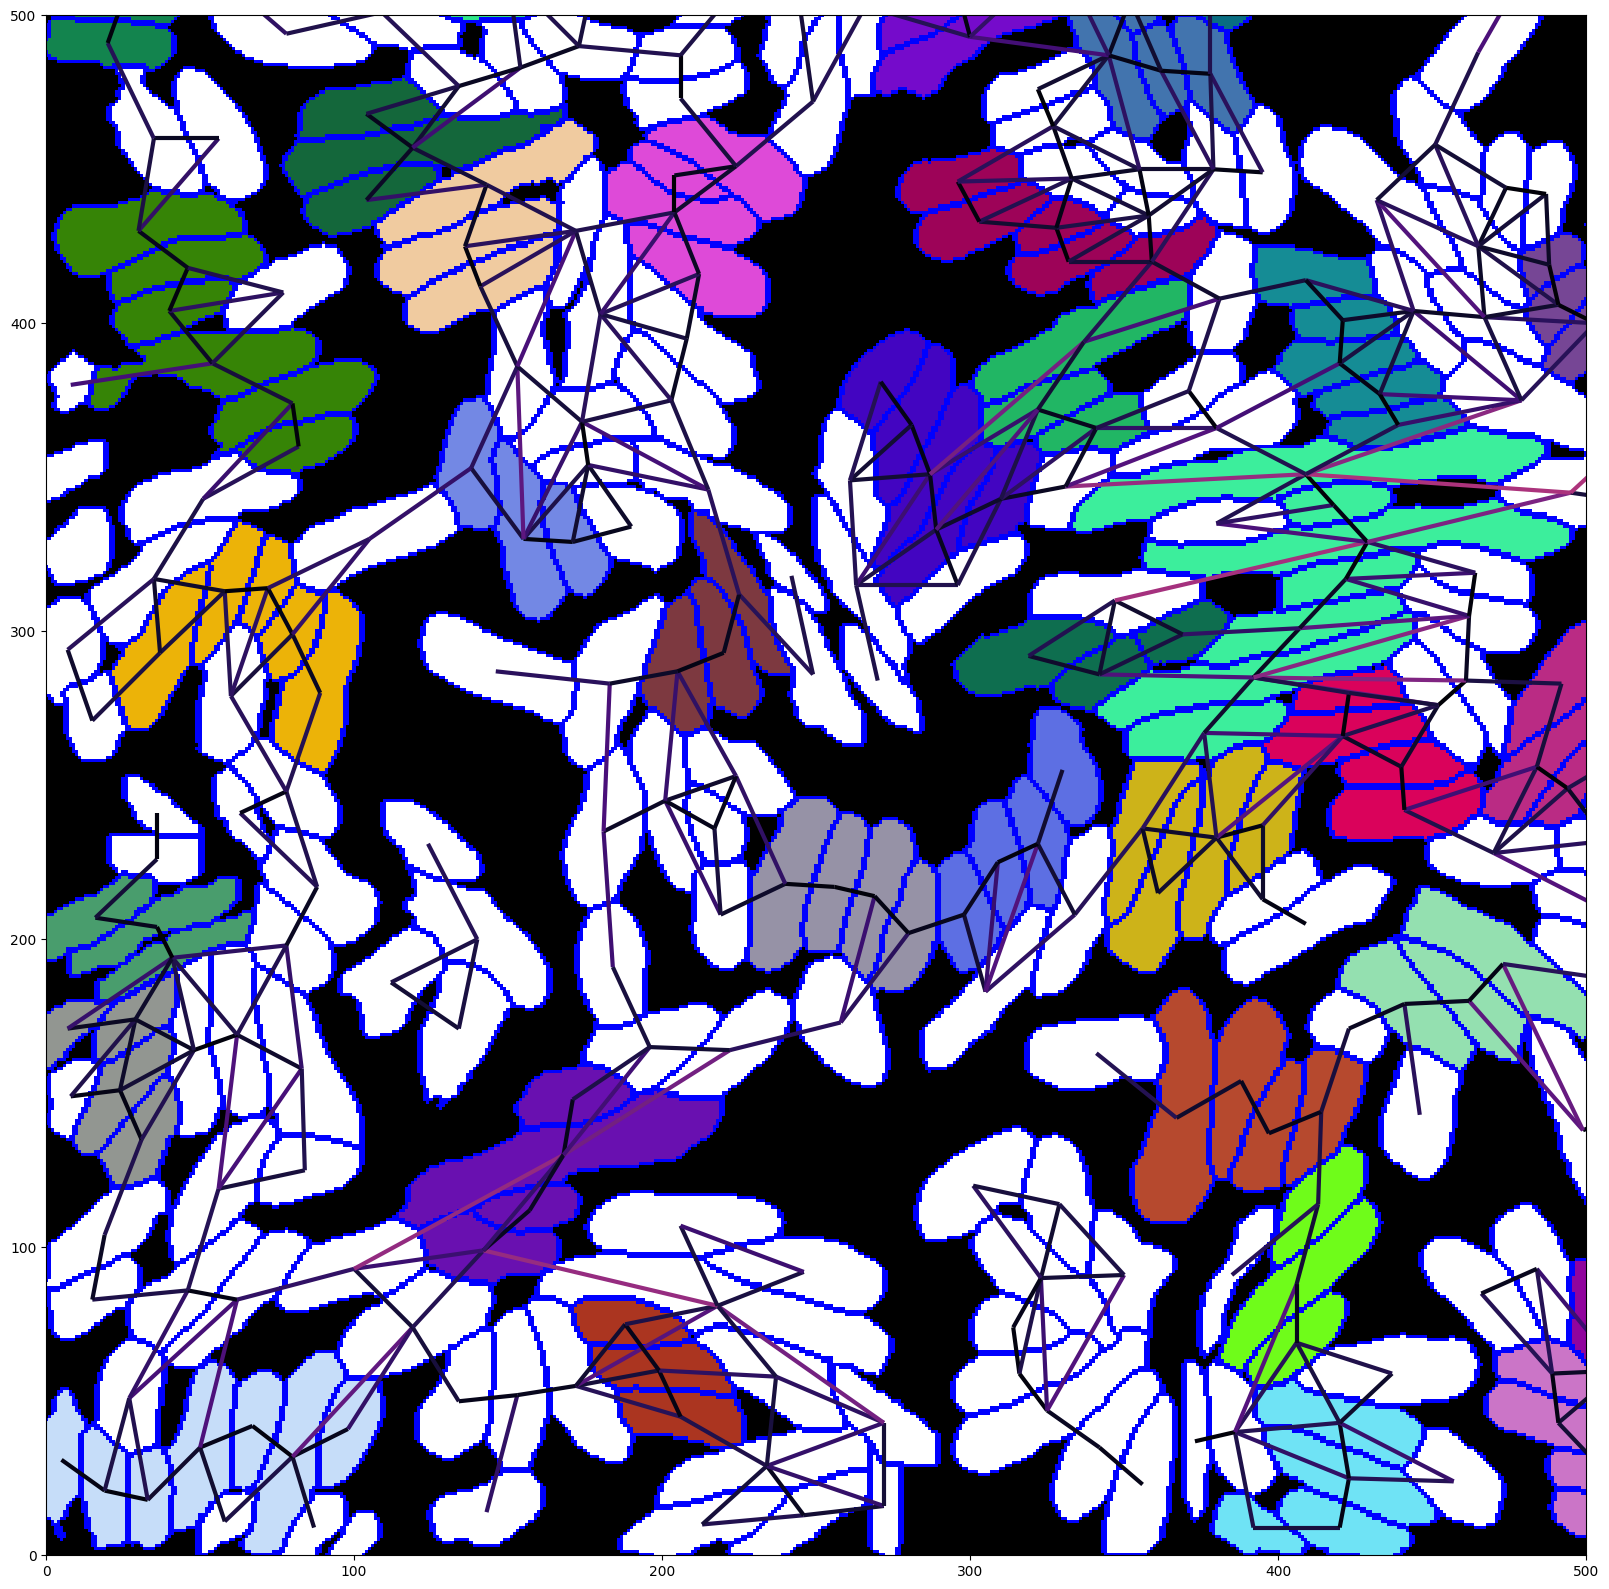

In [279]:
#Lrgb = labels2rgb(L)
Lcluster = labels2rgb(map_attribute(L, rag, 'cluster').astype(int))

fig,ax = plt.subplots(1,1,figsize=(20,20))
show_rag2(L, rag, Lcluster, img_cmap=None, ax=ax, border_color='blue', dataname='centroid_distance', edge_width=3, edge_cmap='magma', hide_zero=True, edge_filter=None, show_filtered=False, ignore_node=0)
rg = (0,500,0,500)
xylim(rg)
plt.savefig('raw_graph_a15_cd30.png')

In [285]:
L.shape

(1048, 1040)

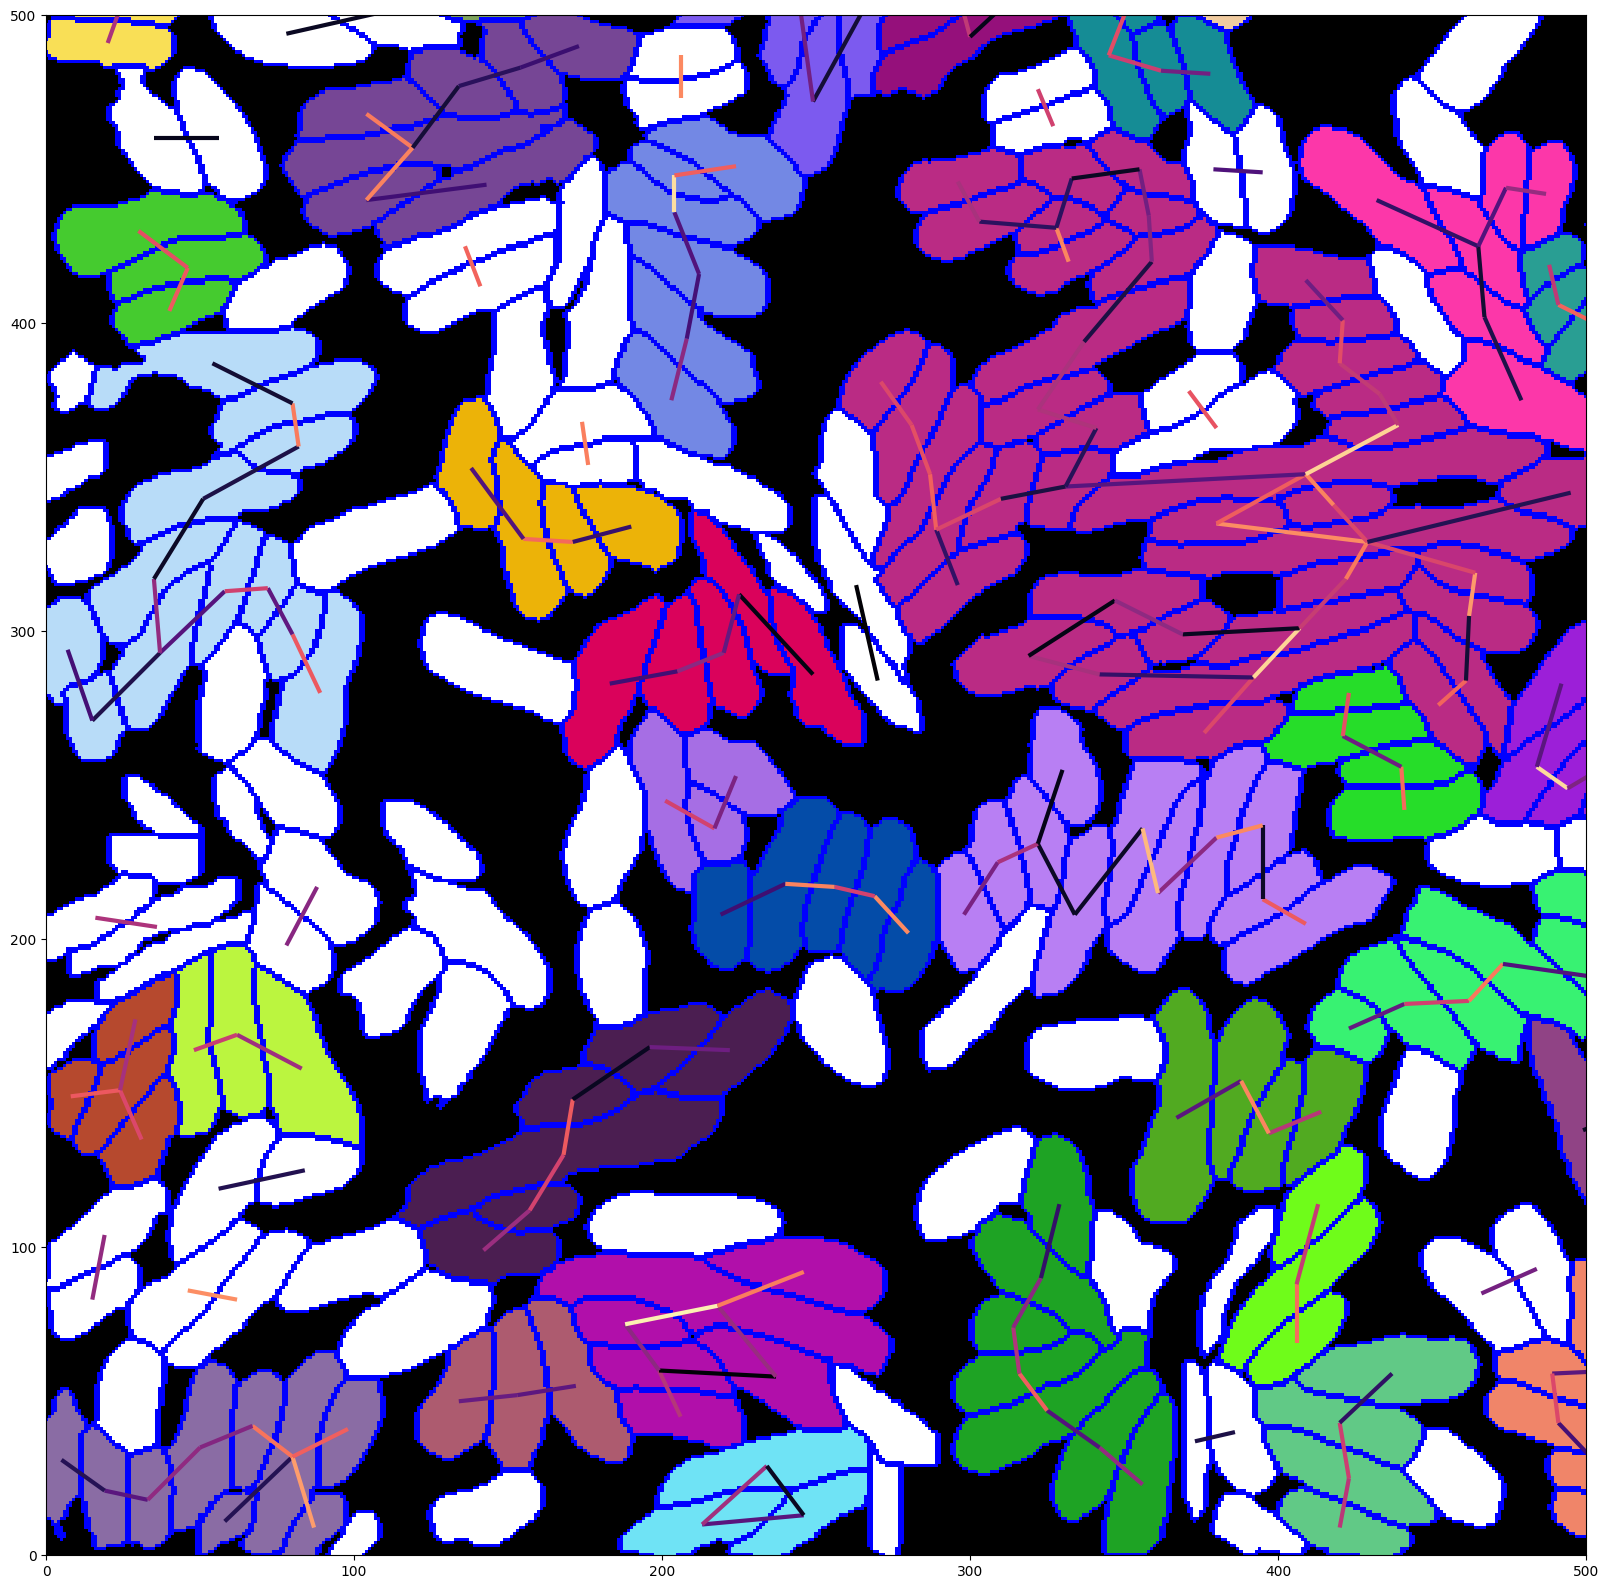

In [293]:
def edge_filter0(rag, u, v, amax=45, mcmin=0.20):
  return ( (rag.get_edge_data(u,v)['relative_angle']<=amax) \
      and (rag.get_edge_data(u,v)['max_count_ratio']>=mcmin) )

rag = skimage.graph.rag_boundary(L, np.ones_like(L,dtype=np.float32))
augment_graph(rag, L)
compute_clusters(rag, min_cluster_size=3, edge_filter=edge_filter0)

LC = map_attribute(L, rag, 'cluster').astype(np.int16)
LCRGB = labels2rgb(LC)

#Lrgb = labels2rgb(L)
Lcluster = labels2rgb(map_attribute(L, rag, 'cluster').astype(int))

fig,ax = plt.subplots(1,1,figsize=(20,20))
show_rag2(L, rag, Lcluster, img_cmap=None, ax=ax, border_color='blue', dataname='max_count_ratio', edge_width=3, edge_cmap='magma', hide_zero=True, edge_filter=edge_filter0, show_filtered=False, ignore_node=0)
rg = (0,500,0,500)
xylim(rg)
plt.savefig('pruned_graph_a45_mc0.20.png')

In [233]:
df = to_pandas_nodelist(rag)
df = df[df.cluster>0].copy()

In [234]:
df

labels   area     angle                                 centroid  \
7        [7]  586.0 -1.258973   [9.448805460750853, 420.3754266211604]   
8        [8]  432.0 -0.143083  [15.034722222222221, 807.0879629629629]   
10      [10]  563.0 -0.013226   [17.05328596802842, 823.7388987566608]   
11      [11]  367.0  0.796472  [10.425068119891009, 887.3569482288829]   
13      [13]  467.0 -1.176955  [11.618843683083512, 988.1070663811563]   
...      ...    ...       ...                                      ...   
1139  [1139]  502.0 -1.505174  [1039.9262948207172, 658.3366533864541]   
341    [341]  690.0  0.573147   [333.4405797101449, 289.7217391304348]   
405    [405]  511.0 -0.602894  [384.79843444227004, 963.7455968688845]   
624    [624]  428.0  1.066319   [570.6355140186915, 772.4415887850467]   
686    [686]  374.0 -0.247647   [639.5080213903743, 43.82085561497326]   

      boundary_count  cluster  
7                245        2  
8                155        3  
10               222        3  
11               191        4  
13               274        5  
...              ...      ...  
1139             236      249  
341              367       71  
405              251       74  
624              224      136  
686              206      151  

[559 rows x 6 columns]

In [236]:
H = compute_clusters(rag, min_cluster_size=3, edge_filter=edge_filter4)

In [241]:
df = nx.to_pandas_edgelist(H)
df

source  target  count  relative_angle  centroid_distance  weight  \
0         4      44    100        3.990150          27.744145     1.0   
1         7      17     41        6.439503          28.118086     1.0   
2         7      38     85        7.008135          16.208022     1.0   
3        38      54    118        8.912963          17.907330     1.0   
4         8      10     30        7.440239          16.772843     1.0   
..      ...     ...    ...             ...                ...     ...   
542    1129    1137     67        6.017271          12.704859     1.0   
543    1114    1122    105        2.538594          17.030590     1.0   
544    1122    1134    116        0.093402          14.549922     1.0   
545    1134    1139     69        7.653990          28.409704     1.0   
546    1133    1144     49       10.975161          12.088962     1.0   

     max_count_ratio  
0           0.330033  
1           0.196172  
2           0.346939  
3           0.359756  
4           0.193548  
..               ...  
542         0.345361  
543         0.368421  
544         0.379085  
545         0.292373  
546         0.195219  

[547 rows x 7 columns]

In [ ]:
LCRGB_boundaries = segmentation.mark_boundaries(LCRGB, L, color=[0,0,255])
plt.imshow(LCRGB_boundaries)
xylim( rg )

# Analysis of cluster properties

In [258]:
df = nx.to_pandas_edgelist(rag)

H = compute_clusters(rag, min_cluster_size=3, edge_filter=edge_filter4)
df2 = nx.to_pandas_edgelist(H)

df = df[ (df.source!=0)&(df.target!=0) ]
df2 = df2[ (df2.source!=0)&(df2.target!=0) ]

plt.plot( df['relative_angle'], df['centroid_distance'], '.' )
plt.plot( df2['relative_angle'], df2['centroid_distance'], 'r.' )
plt.xlabel('relative angle')
plt.ylabel('centroid distance')

Text(0, 0.5, 'centroid distance')

Text(0, 0.5, 'common boundary count')

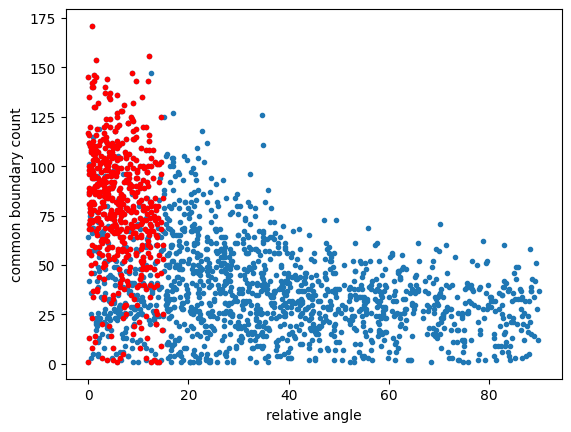

In [259]:
plt.plot( df['relative_angle'], df['count'], '.' )
plt.plot( df2['relative_angle'], df2['count'], 'r.' )
plt.xlabel('relative angle')
plt.ylabel('common boundary count')

# Interactive plots

In [6]:
from dash import Dash, dcc, html, Input, Output, callback

import plotly.express as px

import json
import pandas as pd

In [14]:
P = regionprops(L)

labels = np.array([p.label for p in P])
C = np.array([p.centroid for p in P])
angle = np.array([p.orientation for p in P])
area = np.array([p.area for p in P])

In [16]:
df = pd.DataFrame()
df['x'] = C[:,0]
df['y'] = C[:,1]
df['angle'] = angle
df['area'] = area

fig = px.imshow(L)
fig2 = px.scatter(df, x="x", y="y", color="area", custom_data=["angle"])

fig2.show()

In [41]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = Dash(__name__, external_stylesheets=external_stylesheets)

styles = {
    'pre': {
        'border': 'thin lightgrey solid',
        'overflowX': 'scroll'
    }
}

df = pd.DataFrame({
    "x": [1,2,1,2],
    "y": [1,2,3,4],
    "customdata": [1,2,3,4],
    "fruit": ["apple", "apple", "orange", "orange"]
})

fig = px.scatter(df, x="x", y="y", color="fruit", custom_data=["customdata"])

fig.update_layout(clickmode='event+select')

fig.update_traces(marker_size=20)

app.layout = html.Div([
    dcc.Graph(
        id='basic-interactions',
        figure=fig
    ),

    html.Div(className='row', children=[
        html.Div([
            dcc.Markdown("""
                **Hover Data**

                Mouse over values in the graph.
            """),
            html.Pre(id='hover-data', style=styles['pre'])
        ], className='three columns'),

        html.Div([
            dcc.Markdown("""
                **Click Data**

                Click on points in the graph.
            """),
            html.Pre(id='click-data', style=styles['pre']),
        ], className='three columns'),

        html.Div([
            dcc.Markdown("""
                **Selection Data**

                Choose the lasso or rectangle tool in the graph's menu
                bar and then select points in the graph.

                Note that if `layout.clickmode = 'event+select'`, selection data also
                accumulates (or un-accumulates) selected data if you hold down the shift
                button while clicking.
            """),
            html.Pre(id='selected-data', style=styles['pre']),
        ], className='three columns'),

        html.Div([
            dcc.Markdown("""
                **Zoom and Relayout Data**

                Click and drag on the graph to zoom or click on the zoom
                buttons in the graph's menu bar.
                Clicking on legend items will also fire
                this event.
            """),
            html.Pre(id='relayout-data', style=styles['pre']),
        ], className='three columns')
    ])
])


@callback(
    Output('hover-data', 'children'),
    Input('basic-interactions', 'hoverData'))
def display_hover_data(hoverData):
    return json.dumps(hoverData, indent=2)


@callback(
    Output('click-data', 'children'),
    Input('basic-interactions', 'clickData'))
def display_click_data(clickData):
    return json.dumps(clickData, indent=2)


@callback(
    Output('selected-data', 'children'),
    Input('basic-interactions', 'selectedData'))
def display_selected_data(selectedData):
    return json.dumps(selectedData, indent=2)


@callback(
    Output('relayout-data', 'children'),
    Input('basic-interactions', 'relayoutData'))
def display_relayout_data(relayoutData):
    return json.dumps(relayoutData, indent=2)


In [42]:
app.run(debug=True)

In [ ]:
import napari

napari.run()